In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rtde_control, rtde_receive

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)

In [3]:
from tools.controller import *
controller = CalibrationController(rtde_r, rtde_c)

transform = np.array([[1, 0, 0],
                      [0, 0, -1],
                      [0, 1, 0]])
controller.set_transform(transform)

start_point = controller.get_sensor_pose()[0:3]

In [4]:
import time
from tools.measuring import MeasuringInterface
measuring_interface = MeasuringInterface(controller)

In [5]:
measuring_interface.start_measuring("tmp")
time.sleep(5)
measuring_interface.stop_measuring()

('stop',)


In [6]:
# Top point
controller.move_absolute(start_point[0:3])
top_point_z = controller.find_contact_point([0, 0, -1], 0.005)[2] 
controller.move_absolute(start_point[0:3])

depth = top_point_z - start_point[2] - 0.003

# Double X points
controller.move_relative([0.02, 0.003, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_1 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, 0])

controller.move_relative([0, -0.003 * 2, 0])
x_pose_2 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, -depth])
controller.move_absolute(start_point[0:3])

# Extra x point other side
controller.move_absolute(start_point[0:3])
controller.move_relative([-0.02, 0, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_3 = controller.find_contact_point([1, 0, 0], 0.005)[0:2]
controller.move_relative([-0.005, 0, -depth])
controller.move_absolute(start_point[0:3])


# Single Y point
controller.move_relative([0, 0.02, 0])
controller.move_relative([0.0, 0, depth], 0.01)
y_pose_1 = controller.find_contact_point([0, -1, 0], 0.005)[0:2]
controller.move_relative([0, 0.005, -depth])
controller.move_absolute(start_point[0:3])

poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1])

Width x: 0.023326849853744974, width y: 0


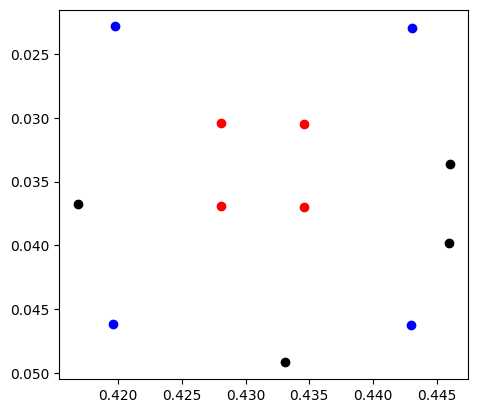

In [7]:
from tools.helpers import *
import matplotlib.pyplot as plt

tool_width = 0.006 / 2 # We want radius
pitch = 0.0065
# 7mm for my design, 6mm for remko design
offset = (0.0063 + pitch / 2, 0.006 + pitch / 2) # Offset should be the position of the first sensor, NOT the corner of the silicon
sensor_grid_size = (2, 2)
nr_of_subpoints = 0

grid_size = (sensor_grid_size[0] + (sensor_grid_size[0] - 1) * nr_of_subpoints, sensor_grid_size[1] + (sensor_grid_size[1] - 1) * nr_of_subpoints )

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
# width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Width x: {width_x}, width y: {0}")

offset = ( (width_x - pitch * (sensor_grid_size[0] - 1)) / 2, offset[1])

corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_x, tool_width)

# Corners index 0 and 3 are the bottom points
# So now we need to calculate the grid based on those

plt.scatter(poses[:, 0], poses[:, 1], c='black')
plt.scatter(corners[:, 0], corners[:, 1], c='blue')

grid = calculate_grid_on_square(corners, offset, grid_size, pitch / (nr_of_subpoints + 1))

plt.scatter(grid[:, :, 0], grid[:, :, 1], c='red')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

In [8]:
# Check if ok
z_clearance = 0.005
duration = 5

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])

        controller.force_mode([0, 0, 1], [0, 0, -5], [0.1,0.1,0.1])
        
        time.sleep(2)
        
        controller.move_relative([0, 0, z_clearance])
        
        time.sleep(duration / (grid_size[0] * grid_size[1]))
  
controller.move_absolute(start_point[0:3])

[0.43315850730373434,
 0.036806367786450245,
 -0.032308611425925844,
 2.220878400694292,
 2.2213058612501175,
 -0.0008593668073476233]

In [9]:
controller.move_absolute(start_point[0:3])

[0.4331126327678415,
 0.03678491654540483,
 -0.03224989427289919,
 2.221065957394788,
 2.2213799252388142,
 -0.0011009878954272685]

In [10]:
def calibrate_taxel(point, nr_of_trials = 3):

  z_clearance = 0.001
  retraction_speed = 0.01
  limits = [0.01, 0.01, 0.01]
  nr_iterations = 300

  controller.move_absolute(start_point[0:3])
          
  # Move above point
  controller.move_absolute([point[0], point[1], top_point_z + z_clearance])

  time.sleep(1)
  rtde_c.zeroFtSensor()
  time.sleep(1)

  #
  # Now apply normal forces
  #
  
  print("Applying normal forces")
  
  
  for n in range(1):
    for f_n in [-1, -5, -10]:
      
        print(f"Applying force {f_n}")
        
        measuring_interface.set_level(-3)
              
        for i in range(nr_iterations):
          if abs(controller.get_sensor_force()[2] - f_n) < 0.05:
            rtde_c.forceModeStop()
          else:
            controller.force_mode([0, 0, 1], [0, 0, f_n], limits)
          time.sleep(0.01)
        
        measuring_interface.set_level(0)
        
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance], retraction_speed)
        time.sleep(1)
        
    time.sleep(10)
        
      
  controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=retraction_speed)
  time.sleep(10)
  
  #
  # Now try X and Y calibration by moving slightly left/right/up/down
  # 
  
  forces = np.array([[1, 5], [2, 5], [5,5]]) # absolute values
  print("Applying X and Y forces")
  for force in forces:
    
    sf, nf = force

    nf *= -1
  
    # Move to start
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=retraction_speed)
    
    time.sleep(1)
    rtde_c.zeroFtSensor()
    time.sleep(1)
    
    # Apply Z
    print(f"Applying Z force {nf}")
    measuring_interface.set_level(-3)
    for i in range(nr_iterations):
      if abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([0, 0, 1], [0, 0, nf], limits)
      time.sleep(0.01)
    measuring_interface.set_level(0)
    
    # Start pose X
    x_start_pose = controller.get_sensor_pose()[0:3]
    
    for n in range(nr_of_trials):
      # Move in direction +X
      print(f"Applying +X force {sf}")
      measuring_interface.set_level(1)
      for i in range(nr_iterations):
        if abs(controller.get_sensor_force()[0] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
          rtde_c.forceModeStop()
        else:
          controller.force_mode([1, 0, 1], [sf, 0, nf], limits)
        time.sleep(0.01)
        
      # Move in direction -X
      print(f"Applying -X force {sf}")
      measuring_interface.set_level(-1)
      sf *= -1
      for i in range(nr_iterations):
        if abs(controller.get_sensor_force()[0] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
          rtde_c.forceModeStop()
        else:
          controller.force_mode([1, 0, 1], [sf, 0, nf], limits)
        time.sleep(0.01)
      sf *= -1
      
    
    # Move back to start pose and up
    measuring_interface.set_level(0)
    controller.move_absolute(x_start_pose, retraction_speed)
    time.sleep(1)
    measuring_interface.set_level(-3)
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=retraction_speed)
    time.sleep(1)
    measuring_interface.set_level(0)
  
  
  
  
    
    # Move to start
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=retraction_speed)
    time.sleep(1)
    rtde_c.zeroFtSensor()
    time.sleep(1)
    
    # Apply Z
    print(f"Applying Z force {nf}")
    measuring_interface.set_level(-3)
    for i in range(nr_iterations):
      if abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([0, 0, 1], [0, 0, nf], limits)
      time.sleep(0.01)
    
    y_start_pose = controller.get_sensor_pose()[0:3]

    for n in range(nr_of_trials):
      # Move in direction +Y
      print(f"Applying +Y force {sf}")
      measuring_interface.set_level(2)
      
      for i in range(nr_iterations):
        if abs(controller.get_sensor_force()[1] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
          rtde_c.forceModeStop()
        else:
          controller.force_mode([0, 1, 1], [0, sf, nf], limits)
        time.sleep(0.01)
        
      # Move in direction -Y
      print(f"Applying -Y force {sf}")
      sf *= -1
      measuring_interface.set_level(-2)
      for i in range(nr_iterations):
        if abs(controller.get_sensor_force()[1] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
          rtde_c.forceModeStop()
        else:
          controller.force_mode([0, 1, 1], [0, sf, nf], limits)
        time.sleep(0.01)
      sf *= -1
    
    # Move back to start pose and up
    measuring_interface.set_level(0)
    controller.move_absolute(y_start_pose, retraction_speed)
    time.sleep(1)
    measuring_interface.set_level(-3)
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=retraction_speed)
    time.sleep(1)
    measuring_interface.set_level(0)
  

In [13]:
controller.move_absolute(start_point[0:3])
time.sleep(1)

measuring_interface.start_measuring("taxel0_calibration_28032024")
time.sleep(3)

for row in grid[1:]:
  for point in row[1:]:
    calibrate_taxel(point)
    
    time.sleep(3)
    measuring_interface.stop_measuring()
    
    break
  break
    # time.sleep(5)

# time.sleep(3)
# measuring_interface.stop_measuring()


Applying normal forces
Applying force -1
('set_level', -3)
('set_level', 0)
Applying force -5
('set_level', -3)
('set_level', 0)
Applying force -10
('set_level', -3)
('set_level', 0)
Applying X and Y forces
Applying Z force -5
('set_level', -3)
Applying +X force 1
('set_level', 0)
('set_level', 1)
Applying -X force 1
('set_level', -1)
Applying +X force 1
('set_level', 1)
Applying -X force 1
('set_level', -1)
Applying +X force 1
('set_level', 1)
Applying -X force 1
('set_level', -1)
('set_level', 0)
('set_level', -3)
('set_level', 0)
Applying Z force -5
('set_level', -3)
Applying +Y force 1
('set_level', 2)
Applying -Y force 1
('set_level', -2)
Applying +Y force 1
('set_level', 2)
Applying -Y force 1
('set_level', -2)
Applying +Y force 1
('set_level', 2)
Applying -Y force 1
('set_level', -2)
('set_level', 0)
('set_level', -3)
('set_level', 0)
Applying Z force -5
('set_level', -3)
Applying +X force 2
('set_level', 0)
('set_level', 1)
Applying -X force 2
('set_level', -1)
Applying +X forc

In [14]:
measuring_interface.stop_measuring()
measuring_interface.tf_q.put(("stop",))
controller.move_absolute(start_point[0:3])


[0.4331217761508818,
 0.03676868403286271,
 -0.032282178482138005,
 2.2270500028804796,
 2.2063582523461394,
 -0.019009060417616543]

In [ ]:

rtde_c.forceModeStop()

In [ ]:
controller.move_absolute(start_point[0:3])

In [ ]:

measuring_interface.stop_measuring()
rtde_c.stopScript()

In [14]:
rtde_c.stopScript()